In [16]:
!wget https://raw.githubusercontent.com/Atcold/pytorch-Deep-Learning/master/res/plot_lib.py

--2024-09-24 01:58:28--  https://raw.githubusercontent.com/Atcold/pytorch-Deep-Learning/master/res/plot_lib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4796 (4.7K) [text/plain]
Saving to: ‘plot_lib.py.6’

plot_lib.py.6       100%[===================>]   4.68K  --.-KB/s    in 0s      

2024-09-24 01:58:28 (45.3 MB/s) - ‘plot_lib.py.6’ saved [4796/4796]



In [17]:
import random
import torch
from torch import nn, optim
import math
from IPython import display
from plot_lib import plot_data, plot_model, set_default

# 因为colab是支持GPU的，torch 将在 GPU 上运行
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ', device)

# 初始化随机数种子。神经网络的参数都是随机初始化的，
# 不同的初始化参数往往会导致不同的结果，当得到比较好的结果时我们通常希望这个结果是可以复现的，
# 因此，在pytorch中，通过设置随机数种子也可以达到这个目的
seed = 12345
random.seed(seed)
torch.manual_seed(seed)

N = 1000  # 每类样本的数量
D = 2  # 每个样本的特征维度
C = 3  # 样本的类别
H = 100  # 神经网络里隐层单元的数量

FileNotFoundError: [Errno 2] No such file or directory: 'res/ziegler.png'

In [19]:
X = torch.zeros(N * C, D).to(device)
Y = torch.zeros(N * C, dtype=torch.long).to(device)
for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N) # 在[0，1]间均匀的取10000个数，赋给t
    # 下面的代码不用理解太多，总之是根据公式计算出三类样本（可以构成螺旋形）
    # torch.randn(N) 是得到 N 个均值为0，方差为 1 的一组随机数，注意要和 rand 区分开
    inner_var = torch.linspace( (2*math.pi/C)*c, (2*math.pi/C)*(2+c), N) + torch.randn(N) * 0.2

    # 每个样本的(x,y)坐标都保存在 X 里
    # Y 里存储的是样本的类别，分别为 [0, 1, 2]
    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * torch.FloatTensor((math.sin(inner_var[index]), math.cos(inner_var[index])))
        Y[ix] = c
        index += 1

print("Shapes:")
print("X:", X.size())
print("Y:", Y.size())

Shapes:
X: torch.Size([3000, 2])
Y: torch.Size([3000])


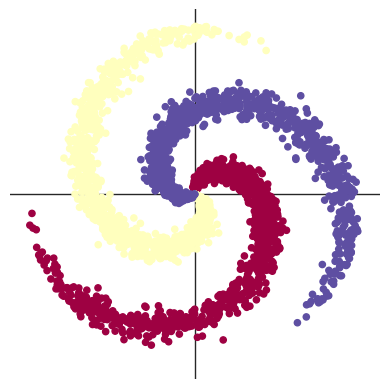

In [20]:
# visualise the data
plot_data(X, Y)

In [21]:
learning_rate = 1e-3
lambda_l2 = 1e-5

# nn 包用来创建线性模型
# 每一个线性模型都包含 weight 和 bias
model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)
model.to(device) # 把模型放到GPU上

# nn 包含多种不同的损失函数，这里使用的是交叉熵（cross entropy loss）损失函数
criterion = torch.nn.CrossEntropyLoss()

# 这里使用 optim 包进行随机梯度下降(stochastic gradient descent)优化
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

# 开始训练
for t in range(1000):
    # 把数据输入模型，得到预测结果
    y_pred = model(X)
    # 计算损失和准确率
    loss = criterion(y_pred, Y)
    score, predicted = torch.max(y_pred, 1)
    acc = (Y == predicted).sum().float() / len(Y)
    print('[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f' % (t, loss.item(), acc))
    display.clear_output(wait=True)

    # 反向传播前把梯度置 0
    optimizer.zero_grad()
    # 反向传播优化
    loss.backward()
    # 更新全部参数
    optimizer.step()

[EPOCH]: 0, [LOSS]: 1.109827, [ACCURACY]: 0.333


AttributeError: 'function' object has no attribute 'clear_output'

In [24]:
print(y_pred.shape)
print(y_pred[10, :])
print(score[10])
print(predicted[10])

torch.Size([3000, 3])
tensor([-0.3867, -0.3719,  0.0657], grad_fn=<SliceBackward0>)
tensor(0.0657, grad_fn=<SelectBackward0>)
tensor(2)


Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=3, bias=True)
)


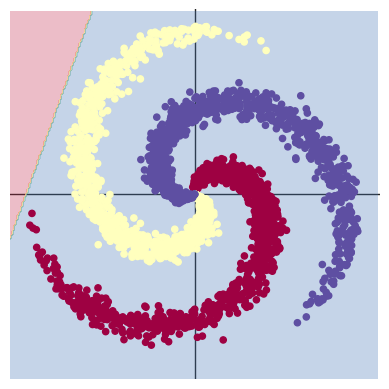

In [23]:
# Plot trained model
print(model)
plot_model(X, Y, model)

In [25]:
learning_rate = 1e-3
lambda_l2 = 1e-5

# 这里可以看到，和上面模型不同的是，在两层之间加入了一个 ReLU 激活函数
model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, C)
)
model.to(device)

# 下面的代码和之前是完全一样的，这里不过多叙述
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# 训练模型，和之前的代码是完全一样的
for t in range(1000):
    y_pred = model(X)
    loss = criterion(y_pred, Y)
    score, predicted = torch.max(y_pred, 1)
    acc = ((Y == predicted).sum().float() / len(Y))
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)

    # zero the gradients before running the backward pass.
    optimizer.zero_grad()
    # Backward pass to compute the gradient
    loss.backward()
    # Update params
    optimizer.step()

[EPOCH]: 0, [LOSS]: 1.123080, [ACCURACY]: 0.186


AttributeError: 'function' object has no attribute 'clear_output'

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=3, bias=True)
)


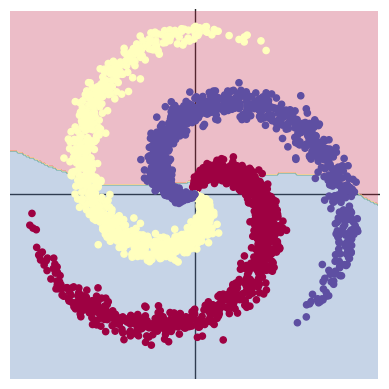

In [26]:
# Plot trained model
print(model)
plot_model(X, Y, model)